In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import plotly.offline as py
from tqdm import tqdm
from sklearn.decomposition import PCA
from prettytable import PrettyTable
from sklearn.metrics import silhouette_score

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)
df_merged_clusterB = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5')
df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,No deaths,58.789954,2.345189,0.136149,2.0
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,No deaths,45.310907,2.345189,0.639968,2.0
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,No deaths,71.662763,2.345189,0.096973,0.0
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,No deaths,70.237122,2.345189,0.534650,2.0
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,All deaths,43.229167,2.345189,0.097775,1.0


# Density-based clustering

DBSCAN: start from data distribution, count #points close to each point, like a circle and overlap. Define a core points: es a point that is close to at least n points (defined by user), randomly pick a core point, assign it to a cluster. Others core points close to the 1st cluster are added (cuz the circle overlap them), go on... then add non-core point if just is close to a core point


# Define a newgranular feaure accordind to disctrics since we're dealing with a state: average incident density per district

In [4]:

# define new indicator variable
df_merged_clusterB['avg_incident_density_per_district'] = df_merged_clusterB.groupby('congressional_district')['density_incident_state'].transform('mean') #avg

#convert death_level to numeric for clustering
df_merged_clusterB['death_level'] = df_merged_clusterB['death_level'].map({'No deaths': 0, 'Some deaths': 1, 'All deaths': 2})
df_merged_clusterB.head()


,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,avg_incident_density_per_district
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,0,58.789954,2.345189,0.136149,2.0,0.332950
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,0,45.310907,2.345189,0.639968,2.0,0.593119
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,0,71.662763,2.345189,0.096973,0.0,0.316859
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,29,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,0,70.237122,2.345189,0.534650,2.0,0.416183
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,2,43.229167,2.345189,0.097775,1.0,0.271355


In [5]:
# show all different values for death_level 
df_merged_clusterB['death_level'].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

# Condider TEXAS since is the state with more weapons

In [6]:
#select column for dbscan
col_clustering_dbscan = ['avg_age_participants','avg_incident_density_per_district','congressional_district','death_level'] 

#take only the columns for dbscan
df_for_dbscan = df_merged_clusterB[col_clustering_dbscan]

#dataframe with onlyt Texas
df_texas =  df_merged_clusterB[df_merged_clusterB['state'] == 'Texas']

#dataframe about Texas with only the columns for dbscan
df_texas_clustering = df_texas[col_clustering_dbscan]

# Standardizzazione dei dati
scaler = StandardScaler()
df_texas_scaled = scaler.fit_transform(df_texas_clustering)

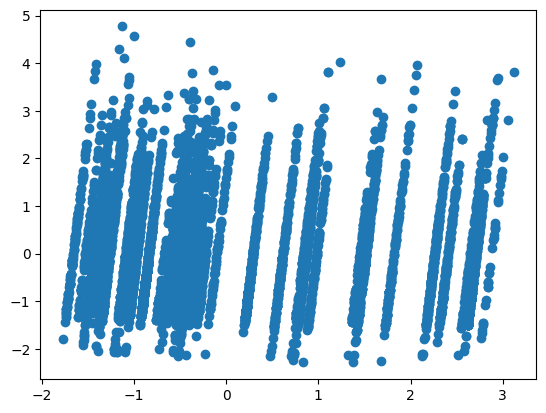

In [7]:
#pca on the new df

pca = PCA(n_components=2)
df_texas_pca = pca.fit_transform(df_texas_scaled)
plt.scatter(df_texas_pca[:,0], df_texas_pca[:,1])

# knee points

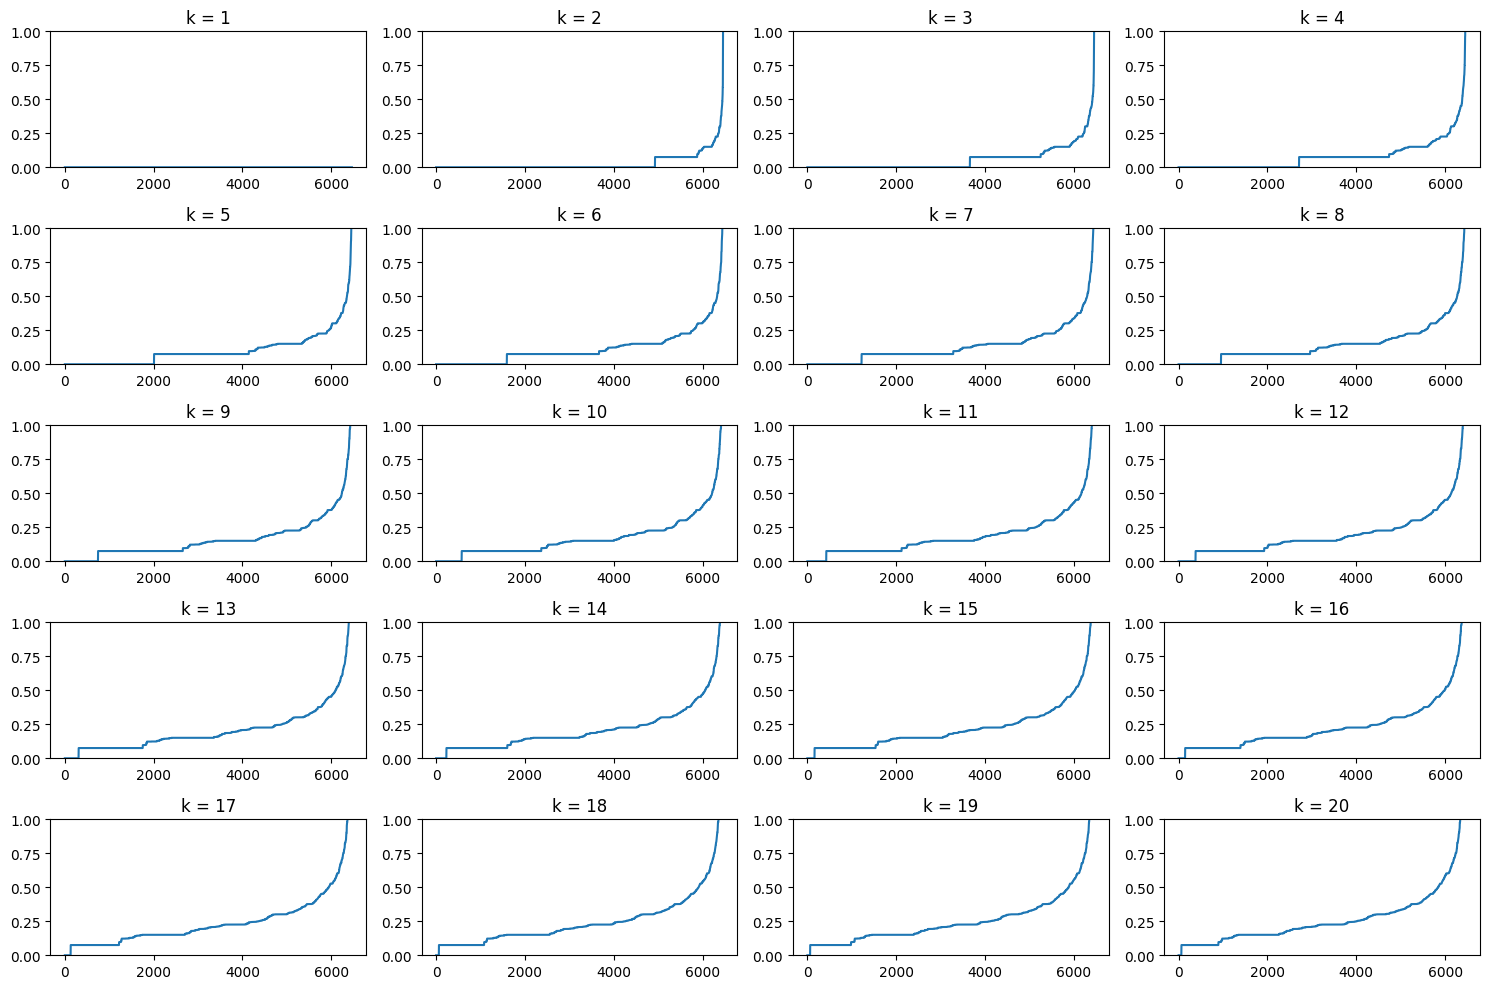

In [ ]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_texas_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_texas_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

In [ ]:
#try to fit dbscan with different values of eps and min_samples by looking at the curves
dbscan= DBSCAN(eps=0.25, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_56752/2787583007.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1     1980
 0     1074
-1      752
 3      554
 7      423
 10     220
 4      187
 6      139
 17     131
 15     119
 12     106
 16     104
 11      91
 8       70
 13      66
 19      48
 5       43
 29      39
 9       32
 25      27
 18      23
 2       22
 20      21
 22      20
 21      19
 32      18
 31      16
 26      16
 28      15
 33      12
 23      12
 14      11
 27      11
 35      10
 24      10
 30       9
 36       9
 34       5
Name: count, dtype: int64

In [ ]:
# more fine grained analysis

def calc_k_nn_dist_graph(X):
    
    # List of k (for k-th nearest neighbour)
    k_list = [5, 10, 15, 20]

    dist = pdist(X, 'euclidean') # pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k
    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.grid()
        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)
        plt.show()

In [ ]:
#prepare function for grid searching

def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    
    # Table with dim = len(eps_list) x len(minpts)
    dbscan_table = list()

    # Iterate over eps (rows)
    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 
        # Iterate over minpts
        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

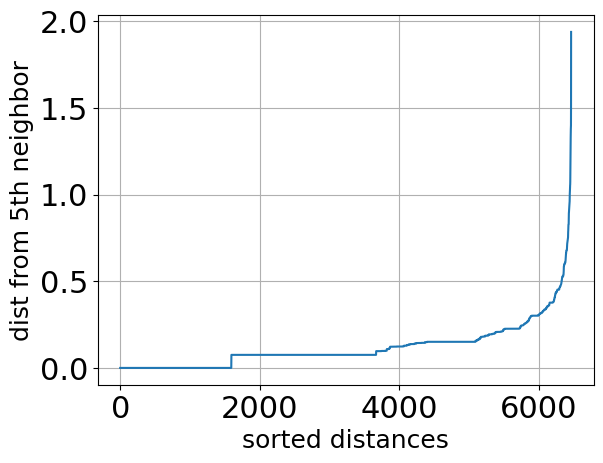

<Figure size 400x100 with 0 Axes>

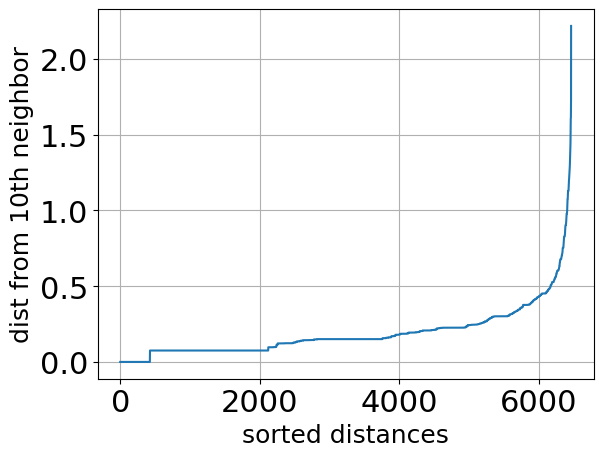

<Figure size 400x100 with 0 Axes>

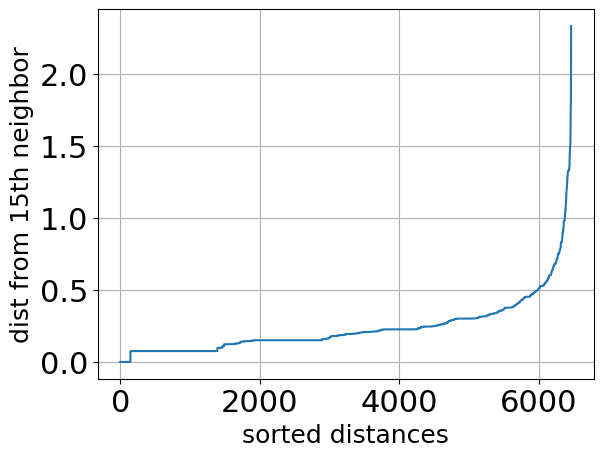

<Figure size 400x100 with 0 Axes>

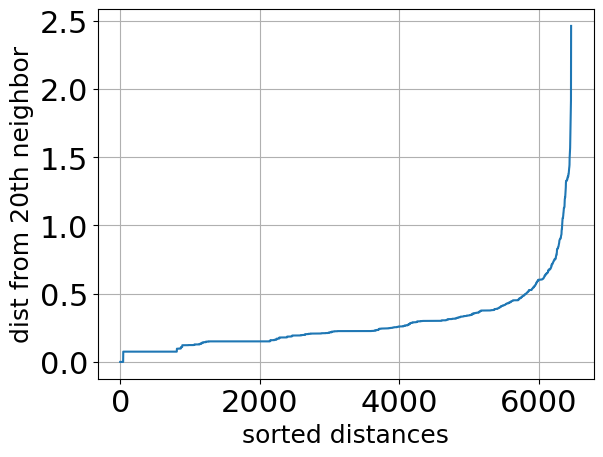

<Figure size 400x100 with 0 Axes>

In [ ]:
calc_k_nn_dist_graph(df_texas_scaled)

# grid search

In [ ]:
# parameters for grid search
eps_list = [0.2, 0.3, 0.4, 0.5, 0.6] 
minpts_list = [5, 10, 15]

# Table with fitted dbscans (rows are eps values, cols are minpts values)
dbscan_table = db_scan_function(df_texas_scaled, eps_list, minpts_list)

5it [00:01,  3.81it/s]


In [ ]:


# define a table for grid search results: score - n_clusters for different eps and minpts
t = PrettyTable()
t.field_names = ['eps\minpts'] + minpts_list

for i, eps in tqdm(enumerate(eps_list)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list), leave=False):
        dbscan = dbscan_table[i][j]

        try: # Exception in case of num_clusters=1
            silhouette = round(silhouette_score(df_texas_scaled, dbscan.labels_), 2)
        except:
            silhouette = np.nan
        cell_str = str(silhouette) + '-n_clust:'+str(len(np.unique(dbscan.labels_))-1)
        row_str.append(cell_str)

    t.add_row(row_str)

print('Results \n')
print(t)

5it [00:09,  1.81s/it]

Results 

+------------+------------------+-----------------+------------------+
| eps\minpts |        5         |        10       |        15        |
+------------+------------------+-----------------+------------------+
|    0.2     | -0.08-n_clust:89 | -0.1-n_clust:60 | -0.16-n_clust:36 |
|    0.3     | 0.05-n_clust:51  | 0.04-n_clust:33 | 0.06-n_clust:25  |
|    0.4     | 0.13-n_clust:27  | 0.15-n_clust:25 | 0.16-n_clust:21  |
|    0.5     | 0.21-n_clust:12  |  0.24-n_clust:9 |  0.24-n_clust:8  |
|    0.6     |  0.13-n_clust:6  |  0.12-n_clust:6 |  0.13-n_clust:5  |
+------------+------------------+-----------------+------------------+


In [ ]:
# run dbsc with beast score

dbscan= DBSCAN(eps=0.5, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_56752/2883629937.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1    2656
 0    1383
 2     779
 4     662
 5     436
 6     239
 3     144
-1     126
 7      25
 8      14
Name: count, dtype: int64

In [ ]:
print('count of elements for each cluster\n')

for i, eps in enumerate(eps_list):
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table[i][j]
        n_clusters = len(np.unique(dbscan.labels_))-1 # -1 to exclude outlier label
        occ_list = []
        for k in range(-1, n_clusters):
             occ_list.append(np.count_nonzero(dbscan.labels_ == k))
        print('eps:', eps, ', minpts:', minpts, '-', occ_list)

count of elements for each cluster

eps: 0.2 , minpts: 5 - [618, 661, 1409, 119, 6, 23, 322, 185, 45, 292, 141, 25, 181, 69, 209, 237, 68, 14, 214, 33, 116, 176, 32, 111, 6, 105, 67, 9, 103, 25, 147, 39, 15, 7, 48, 21, 59, 15, 6, 10, 14, 10, 7, 22, 7, 13, 10, 14, 10, 6, 16, 23, 5, 5, 8, 14, 16, 10, 5, 5, 41, 28, 9, 8, 7, 5, 6, 8, 12, 11, 6, 6, 7, 8, 9, 10, 5, 6, 3, 6, 5, 4, 5, 5, 9, 7, 4, 5, 5, 6]
eps: 0.2 , minpts: 10 - [1386, 228, 1342, 183, 37, 264, 134, 374, 181, 68, 221, 199, 220, 42, 212, 112, 162, 27, 93, 28, 83, 16, 41, 21, 5, 99, 91, 126, 18, 10, 19, 18, 17, 21, 12, 24, 10, 20, 36, 16, 14, 21, 17, 22, 12, 14, 21, 7, 13, 8, 13, 9, 10, 10, 8, 6, 9, 10, 8, 10, 6]
eps: 0.2 , minpts: 15 - [2216, 190, 1274, 183, 22, 262, 132, 322, 181, 150, 191, 209, 185, 139, 22, 72, 21, 25, 48, 85, 91, 124, 17, 22, 45, 35, 22, 17, 15, 16, 31, 26, 18, 11, 18, 12, 15]
eps: 0.3 , minpts: 5 - [307, 1130, 2078, 120, 33, 52, 613, 201, 47, 142, 26, 438, 70, 35, 36, 235, 107, 123, 5, 112, 67, 13, 149, 48,

In [ ]:
# grid search result eps: 0.5 , minpts: 10 - [126, 1383, 2656, 779, 144, 662, 436, 239, 25, 14]
dbscan= DBSCAN(eps=0.5, min_samples=10).fit(df_texas_scaled)
df_texas['cluster_dbscan'] = dbscan.labels_
df_texas['cluster_dbscan'].value_counts()

/tmp/ipykernel_56752/2423070765.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster_dbscan
 1    2656
 0    1383
 2     779
 4     662
 5     436
 6     239
 3     144
-1     126
 7      25
 8      14
Name: count, dtype: int64

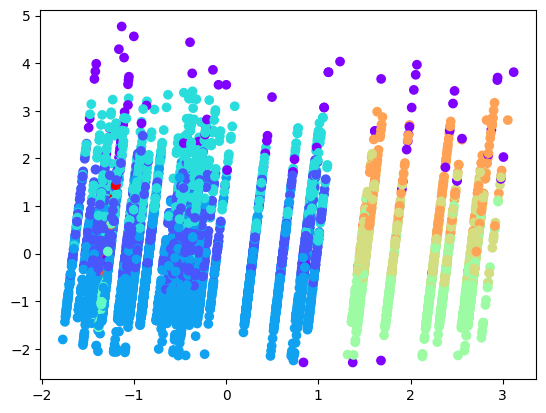

In [ ]:
plt.scatter(df_texas_pca[:,0], df_texas_pca[:,1], c=df_texas['cluster_dbscan'], cmap='rainbow')

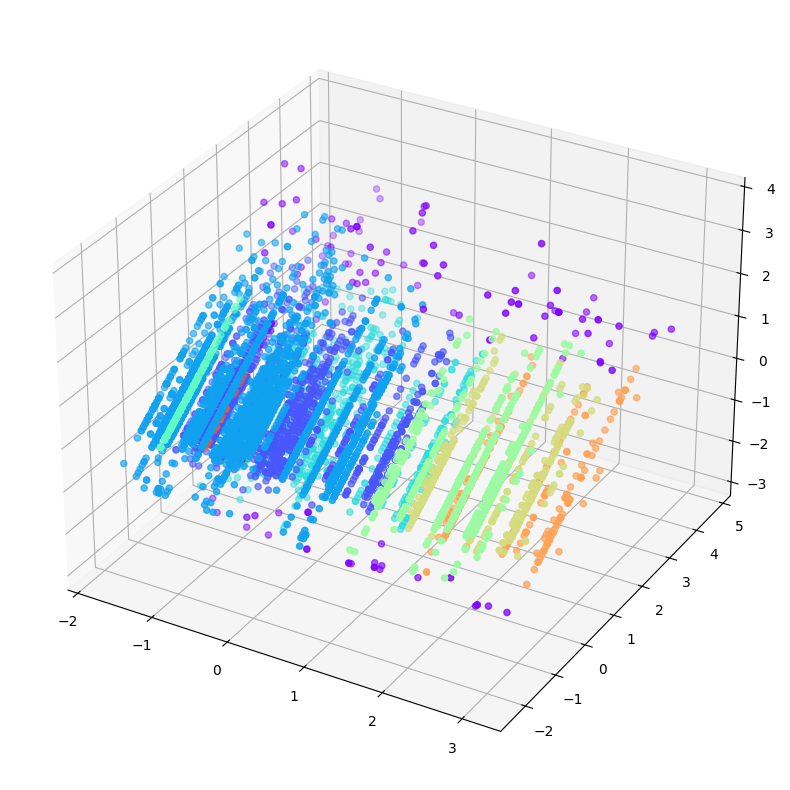

In [ ]:
#plot 3d
pca= PCA(n_components=3)
df_texas_pca = pca.fit_transform(df_texas_scaled)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_texas_pca[:,0], df_texas_pca[:,1], df_texas_pca[:,2], c=df_texas['cluster_dbscan'], cmap='rainbow')

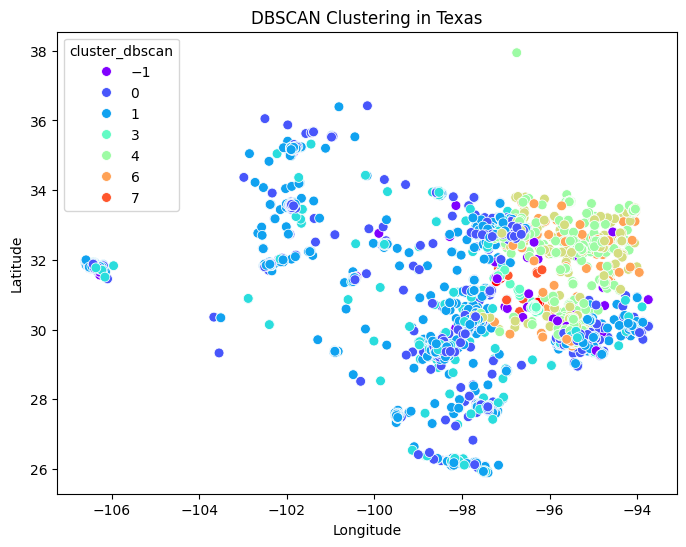

In [ ]:
# plot dbsca result according to latitude and longitude
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster_dbscan', data=df_texas, palette='rainbow', s=50)
plt.title('DBSCAN Clustering in Texas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

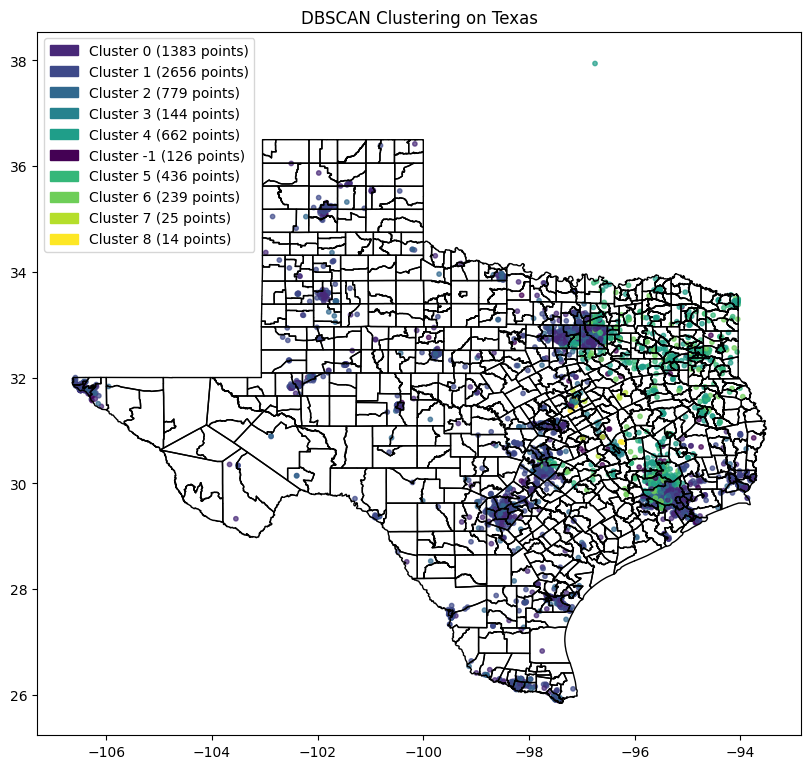

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

# Load the shapefile of Texas
texas_shapefile = '../../map_data/texas_shape.shp'
texas_map = gpd.read_file(texas_shapefile)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)

# Get the unique clusters
clusters = df_texas['cluster_dbscan'].unique()

# Create a colormap
cmap = plt.cm.viridis

# Restrict only to Illinois state
df_merged_clustering = df_texas[df_texas['state'] == 'Texas']

# Normalize the colormap
norm = plt.Normalize(df_texas['cluster_dbscan'].min(), df_texas['cluster_dbscan'].max())

# Create a scatter plot
sc = plt.scatter(df_texas['longitude'][:6464], df_texas['latitude'][:6464],
                 c=df_texas['cluster_dbscan'][:6464], cmap='viridis', s=10, alpha=0.7)

# Plot the Illinois state boundaries
texas_map.plot(ax=plt.gca(), color='none', edgecolor='black')

# Calculate cluster sizes
cluster_sizes = df_texas['cluster_dbscan'].value_counts()

# Create a list of patches for the legend including cluster size
patches = [mpatches.Patch(color=cmap(norm(cluster)), label=f'Cluster {cluster} ({cluster_sizes[cluster]} points)') for cluster in clusters]

# Add the legend to the plot
plt.legend(handles=patches)

plt.title('DBSCAN Clustering on Texas')
plt.tight_layout()
plt.show()

Clusters reflect the population density, according to the big cities: incidents follow the population density 

Silhouette Score: 0.23592074474604594


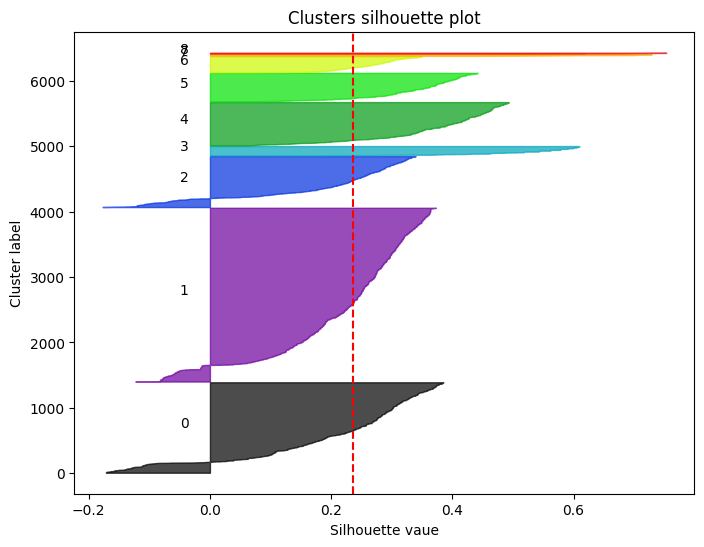

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# silhouette score shape
labels = df_texas['cluster_dbscan']

#avg score
silhouette_avg = silhouette_score(df_texas_scaled, labels)
print("Silhouette Score:", silhouette_avg)

# Calcola la silhouette score per ogni campione
sample_silhouette_values = silhouette_samples(df_texas_scaled, labels)

# plot silhouette 
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10

# Loop through each cluster label
for i in range(max(labels) + 1):
    
    # Extract silhouette values for each data point in the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    
    # Sort silhouette values in ascending order
    ith_cluster_silhouette_values.sort()
    
    # Calculate the size of the current cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    # Define upper and lower y-values for the cluster's silhouette plot
    y_upper = y_lower + size_cluster_i

    # unique color for the current cluster
    color = cm.nipy_spectral(float(i) / (max(labels) + 1))
    
    # Fill the area between y_lower and y_upper with the silhouette values
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Add cluster labels as text annotations
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Update y_lower for the next cluster plot, adding a small gap between clusters
    y_lower = y_upper + 10

ax.set_title("Clusters silhouette plot")
ax.set_xlabel("Silhouette vaue")
ax.set_ylabel("Cluster label")

# avg silhouette score (red dotted line)) 
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()

Min-max scaler

In [ ]:
#standardize data with min max scaler
scaler = MinMaxScaler()
df_texas_scaled_minmax = scaler.fit_transform(df_texas_clustering)


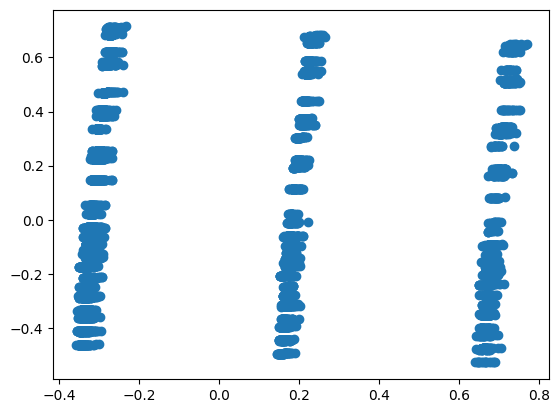

In [ ]:
#pca on the new df
pca = PCA(n_components=2)
df_texas_pca_minmax = pca.fit_transform(df_texas_scaled_minmax)
plt.scatter(df_texas_pca_minmax[:,0], df_texas_pca_minmax[:,1])

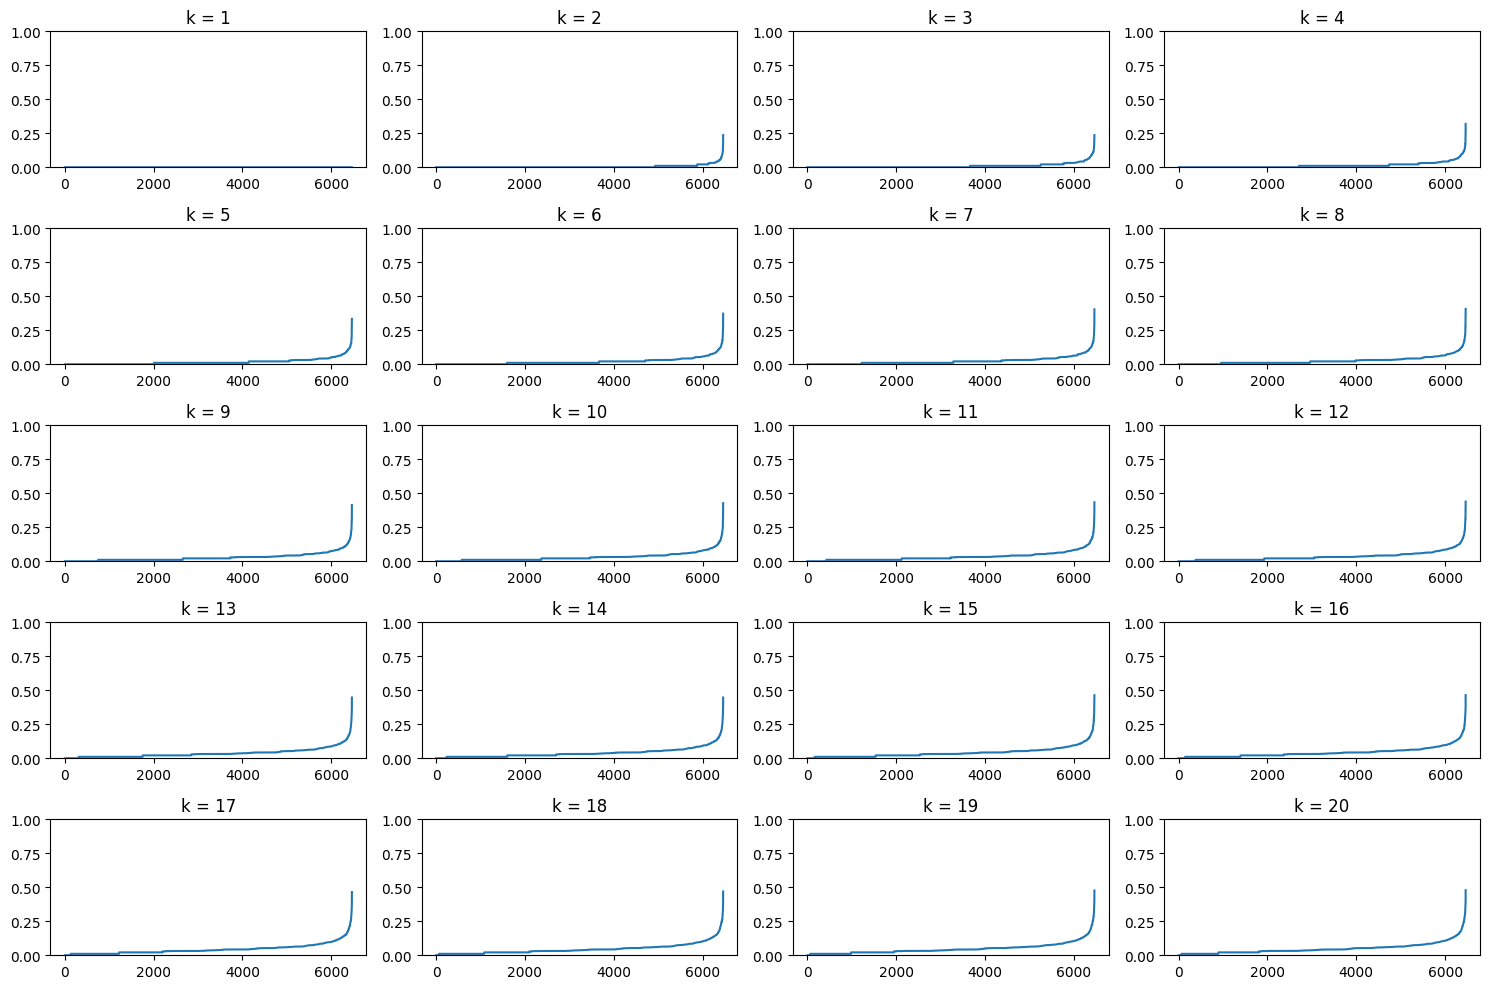

In [ ]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs_minmax = NearestNeighbors(n_neighbors=max_k).fit(df_texas_scaled_minmax)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs_minmax.kneighbors(df_texas_scaled_minmax)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

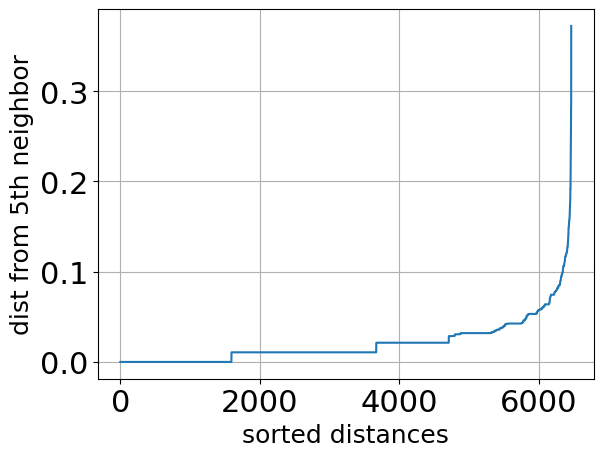

<Figure size 400x100 with 0 Axes>

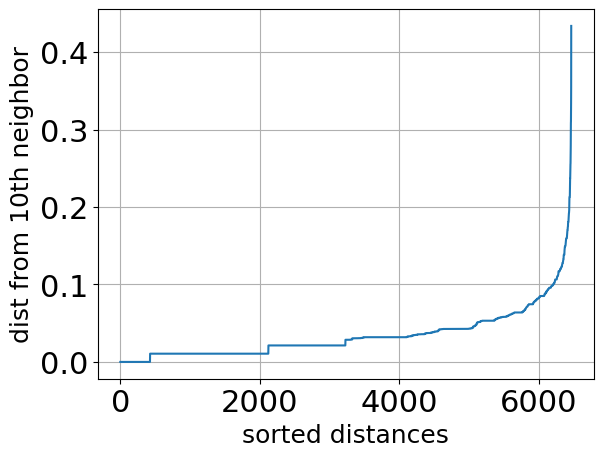

<Figure size 400x100 with 0 Axes>

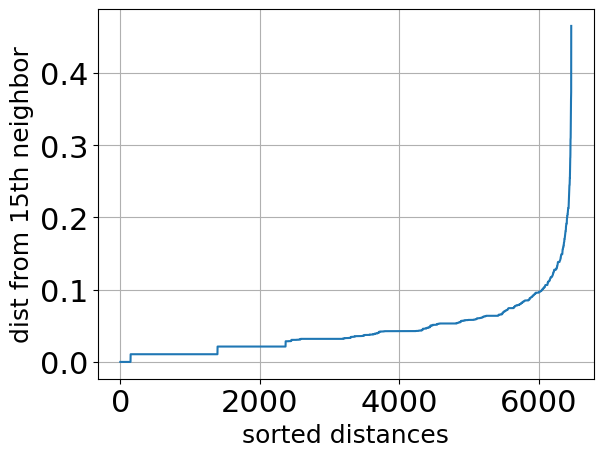

<Figure size 400x100 with 0 Axes>

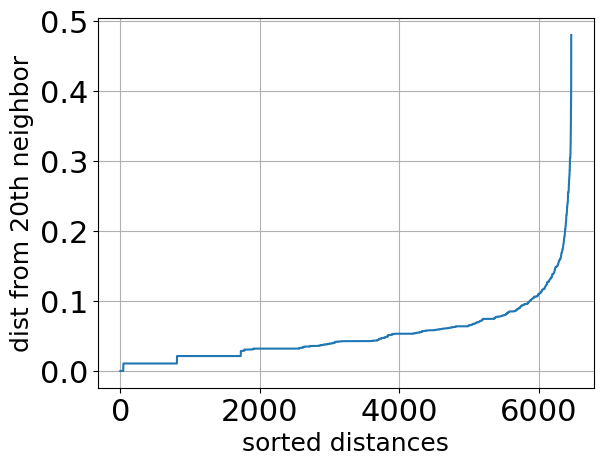

<Figure size 400x100 with 0 Axes>

In [ ]:
calc_k_nn_dist_graph(df_texas_scaled_minmax)

In [ ]:
# parameters for grid search
eps_list_minmax = [0.01, 0.03, 0.05, 0.07, 0.08, 0.1, 0.2] 
minpts_list_minmax = [5, 10, 15, 20]

# Table with fitted dbscans (rows are eps values, cols are minpts values)
dbscan_table_minmax = db_scan_function(df_texas_scaled_minmax, eps_list_minmax, minpts_list_minmax)

# define a table for grid search results: score - n_clusters for different eps and minpts
tab_minmax = PrettyTable()
tab_minmax.field_names = ['eps\minpts'] + minpts_list_minmax

for i, eps in tqdm(enumerate(eps_list_minmax)):
    row_str = [str(eps)]
    for j, minpts  in tqdm(enumerate(minpts_list_minmax), leave=False):
        dbscan_minmax = dbscan_table_minmax[i][j]

        try: # Exception in case of num_clusters=1
            silhouette_minmax = round(silhouette_score(df_texas_scaled_minmax, dbscan_minmax.labels_), 2)
        except:
            silhouette_minmax = np.nan
        cell_str = str(silhouette_minmax) + '-n_clust:'+str(len(np.unique(dbscan_minmax.labels_))-1)
        row_str.append(cell_str)

    tab_minmax.add_row(row_str)

print('Results \n')
print(tab_minmax)

7it [00:01,  4.49it/s]
7it [00:16,  2.41s/it]

Results 

+------------+-------------------+------------------+------------------+------------------+
| eps\minpts |         5         |        10        |        15        |        20        |
+------------+-------------------+------------------+------------------+------------------+
|    0.01    | -0.26-n_clust:273 | -0.56-n_clust:45 |  -0.3-n_clust:9  | -0.21-n_clust:3  |
|    0.03    | -0.06-n_clust:168 | -0.17-n_clust:86 | -0.25-n_clust:48 | -0.34-n_clust:34 |
|    0.05    |  0.02-n_clust:75  | -0.05-n_clust:60 | -0.05-n_clust:47 | -0.09-n_clust:39 |
|    0.07    |  0.17-n_clust:38  | 0.22-n_clust:30  | 0.21-n_clust:27  | 0.21-n_clust:22  |
|    0.08    |  0.25-n_clust:26  | 0.27-n_clust:24  | 0.26-n_clust:21  | 0.25-n_clust:19  |
|    0.1     |  0.25-n_clust:15  | 0.25-n_clust:15  | 0.25-n_clust:13  | 0.25-n_clust:14  |
|    0.2     |   0.16-n_clust:6  |  0.16-n_clust:6  |  0.16-n_clust:6  |  0.16-n_clust:6  |
+------------+-------------------+------------------+-----------------

In [ ]:
# run dbsc with best score 
# 0.27-n_clust:24     0.08     10 

dbscan_minmax= DBSCAN(eps=0.08, min_samples=10).fit(df_texas_scaled_minmax)
df_texas['cluster_dbscan'] = dbscan_minmax.labels_
df_texas['cluster_dbscan'].value_counts()
print('count of elements for each cluster\n')

for i, eps in enumerate(eps_list_minmax):
    for j, minpts  in enumerate(minpts_list_minmax):
        dbscan_minmax = dbscan_table_minmax[i][j]
        n_clusters = len(np.unique(dbscan_minmax.labels_))-1 # -1 to exclude outlier label
        occ_list = []
        for k in range(-1, n_clusters):
             occ_list.append(np.count_nonzero(dbscan.labels_ == k))
        print('eps:', eps, ', minpts:', minpts, '-', occ_list)



count of elements for each cluster

eps: 0.01 , minpts: 5 - [126, 1383, 2656, 779, 144, 662, 436, 239, 25, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
eps: 0.01 , minpts: 10 - [126, 1383, 2656, 779, 144, 662, 436, 239, 25, 14, 0, 0, 0, 0, 0, 0, 0, 

/tmp/ipykernel_56752/1509093963.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



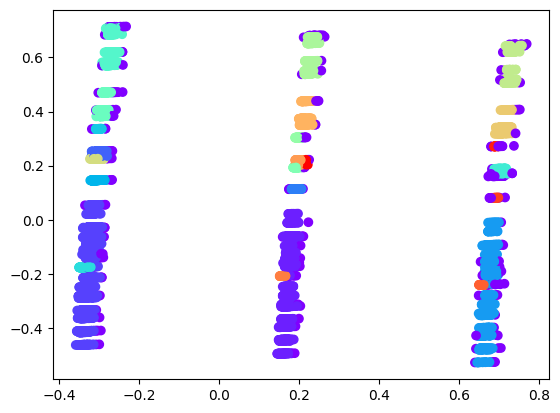

In [ ]:
plt.scatter(df_texas_pca_minmax[:,0], df_texas_pca_minmax[:,1], c=df_texas['cluster_dbscan'], cmap='rainbow') 


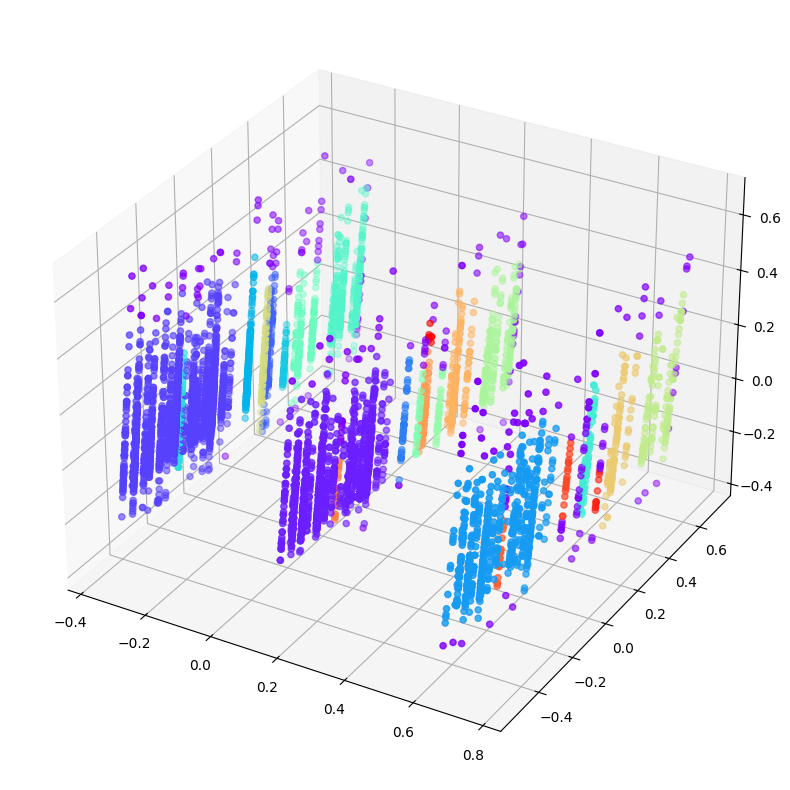

In [ ]:
#plot 3d
pca3= PCA(n_components=3)
df_texas_pca3_minmax = pca3.fit_transform(df_texas_scaled_minmax)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_texas_pca3_minmax[:,0], df_texas_pca3_minmax[:,1], df_texas_pca3_minmax[:,2], c=df_texas['cluster_dbscan'], cmap='rainbow')

Text(0.5, 1.0, 'DBSCAN')

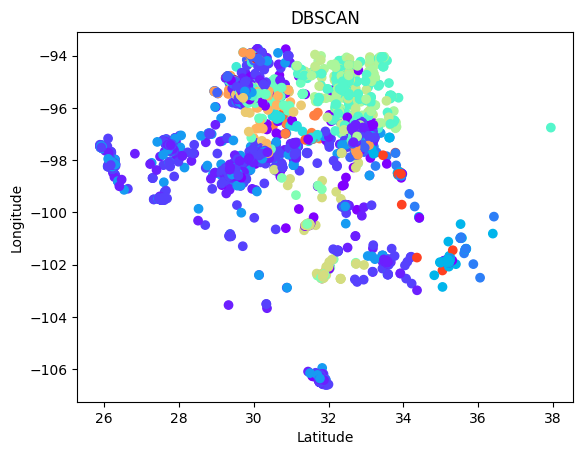

In [ ]:
# get latitude and longitude
latitude_longitude = df_texas[['latitude', 'longitude']]

df_texas_plot = pd.concat([latitude_longitude, df_texas['cluster_dbscan']], axis=1)


plt.scatter(df_texas_plot['latitude'], df_texas_plot['longitude'], c=df_texas_plot['cluster_dbscan'], cmap='rainbow')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('DBSCAN')

Silhouette Score: 0.2688376088506317


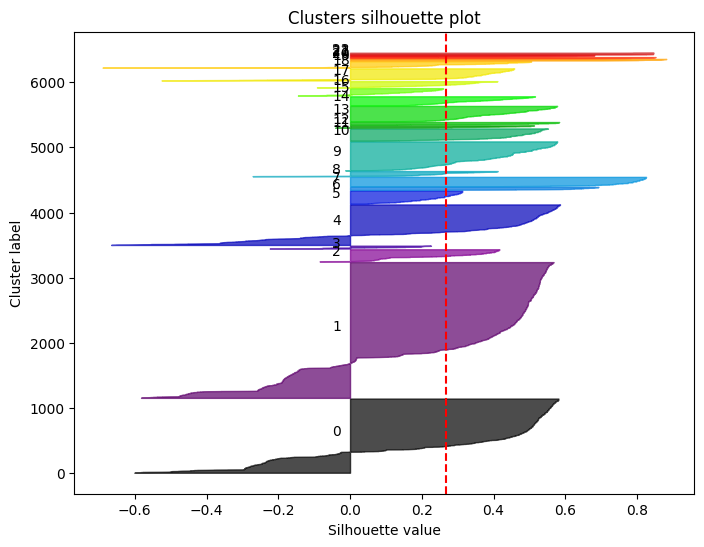

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# silhouette score shape
labels = df_texas['cluster_dbscan']

#avg score
silhouette_avg_minmax = silhouette_score(df_texas_scaled_minmax, labels)
print("Silhouette Score:", silhouette_avg_minmax)

# Calcola la silhouette score per ogni campione
sample_silhouette_values = silhouette_samples(df_texas_scaled_minmax, labels)

# plot silhouette 
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10

# Loop through each cluster label
for i in range(max(labels) + 1):
    
    # Extract silhouette values for each data point in the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    
    # Sort silhouette values in ascending order
    ith_cluster_silhouette_values.sort()
    
    # Calculate the size of the current cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    # Define upper and lower y-values for the cluster's silhouette plot
    y_upper = y_lower + size_cluster_i

    # unique color for the current cluster
    color = cm.nipy_spectral(float(i) / (max(labels) + 1))
    
    # Fill the area between y_lower and y_upper with the silhouette values
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Add cluster labels as text annotations
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Update y_lower for the next cluster plot, adding a small gap between clusters
    y_lower = y_upper + 10

ax.set_title("Clusters silhouette plot")
ax.set_xlabel("Silhouette value")
ax.set_ylabel("Cluster label")

# avg silhouette score (red dotted line)) 
ax.axvline(x=silhouette_avg_minmax, color="red", linestyle="--")

plt.show()

# PYCLUSTERING

In [ ]:
import numpy as np

print("Versione di NumPy:", np.__version__)

Versione di NumPy: 1.23.5


# MBSAS

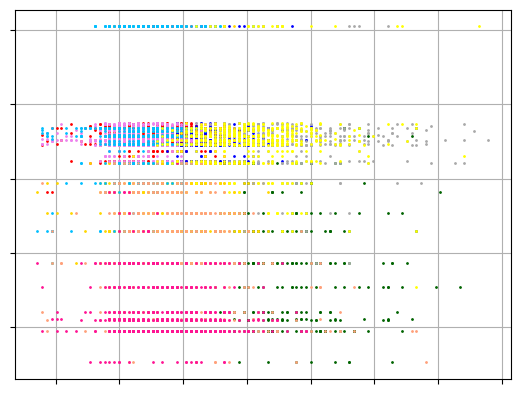

Numero totale di cluster: 10
Cluster 0: 1222 elementi
Caratteristiche del cluster:
                 0            1            2            3
count  1222.000000  1222.000000  1222.000000  1222.000000
mean     -0.434820     0.576965     0.653726     0.863710
std       0.506974     0.280918     0.641884     0.594874
min      -2.212838    -0.705592    -1.199462     0.493013
25%      -0.857700     0.473236     0.057358     0.493013
50%      -0.481273     0.536443     0.830785     0.493013
75%      -0.104845     0.645531     1.217499     1.817551
max       0.873866     2.054602     1.604213     1.817551


Cluster 1: 572 elementi
Caratteristiche del cluster:
                0           1           2           3
count  572.000000  572.000000  572.000000  572.000000
mean     0.459401    0.538247    0.666669   -0.826893
std      0.460516    0.240925    0.534708    0.078253
min     -0.405987    0.209808   -0.619391   -0.831524
25%      0.121011    0.452232    0.250715   -0.831524
50%      0.42215

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.mbsas import mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import warnings
np.warnings = warnings

# MBSAS parameters
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizialize clusters via K-Means++
initial_centers = kmeans_plusplus_initializer(df_texas_scaled, sample_size).initialize()

# MBSAS
mbsas_instance = mbsas(df_texas_scaled, len(initial_centers), threshold, min_cluster_size)
mbsas_instance.process()

# get clusters results
clusters = mbsas_instance.get_clusters()

# noise points not belongign to any cluster
noise_indices = [point_index for cluster in clusters for point_index in cluster]
all_points = set(range(len(df_texas_scaled)))
noise_indices = list(all_points - set(noise_indices))


# clusters visualization
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_texas_scaled[:, 0:2], markersize=2)
visualizer.append_cluster(noise_indices, df_texas_scaled[:, 0:2], marker='x', markersize=5)
visualizer.show()

# Converti l'array NumPy in un DataFrame di pandas
df_texas_scaled_df = pd.DataFrame(df_texas_scaled)

# clusters infos
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_texas_scaled_df.iloc[cluster].describe())
    print("\n")

# noise
print(f"Cluster NOISE (outlier): {len(noise_indices)} elementi")

In [ ]:
'''
15 minutes and still running: get new laptops

from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS
from sklearn.decomposition import PCA

# mbsas with same columns taken for dbscan
col_clustering_mbsas= ['avg_age_participants','avg_incident_density_per_district','congressional_district','death_level'] 
# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]


scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

max_clusters = 10
threshold = 1.0


initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], max_clusters).initialize()  


mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], max_clusters, threshold)  
mbsas_instance.process()

clusters = mbsas_instance.get_clusters()


pca = PCA(n_components=3)
df_for_mbsas_pca = pca.fit_transform(df_for_mbsas_scaled)

visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_pca, markersize=2)
visualizer.show()
'''

"\n15 minutes and still running: get new laptops\n\nfrom pyclustering.cluster import cluster_visualizer, mbsas\nfrom pyclustering.cluster.center_initializer import kmeans_plusplus_initializer\nfrom sklearn.preprocessing import StandardScaler\nfrom pyclustering.cluster.mbsas import mbsas as MBSAS\nfrom sklearn.decomposition import PCA\n\n# mbsas with same columns taken for dbscan\ncol_clustering_mbsas= ['avg_age_participants','avg_incident_density_per_district','congressional_district','death_level'] \n# Crea un DataFrame con le colonne selezionate\ndf_for_mbsas = df_merged_clusterB[col_clustering_mbsas]\n\n\nscaler = StandardScaler()\ndf_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)\n\nmax_clusters = 10\nthreshold = 1.0\n\n\ninitial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], max_clusters).initialize()  \n\n\nmbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], max_clusters, threshold)  \nmbsas_instance.process()\n\nclusters = mbsas_instance.get_clusters()

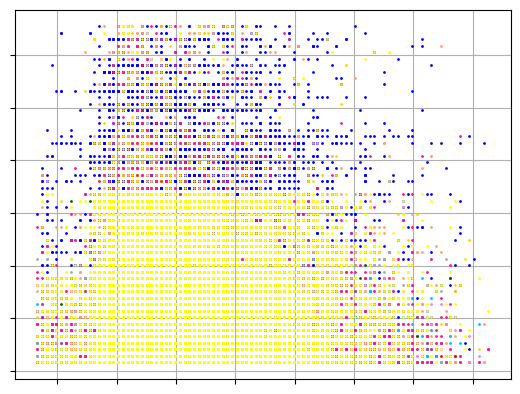

Numero totale di cluster: 10
Cluster 0: 7296 elementi
       percentage_injured  unharmed_ratio  males_to_females_ratio  \
count         7296.000000     7296.000000             7296.000000   
mean            54.590489        7.121956                1.549137   
std              4.553580        2.905695                0.717337   
min             36.518325        2.345189                0.000000   
25%             49.906191        6.948837                1.000000   
50%             57.850857        7.498870                1.000000   
75%             57.850857       10.512655                2.000000   
max             58.789954       10.512655                4.000000   

          totalvotes  povertyPercentage  density_incident_state  \
count    7296.000000        7296.000000             7296.000000   
mean   253640.944216          19.364926                0.304527   
std     48379.103652           1.092749                0.139132   
min     72454.000000          14.200000                0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyclustering.cluster import mbsas, cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustering.cluster.mbsas import mbsas as MBSAS

col_clustering_mbsas = ['percentage_injured', 'unharmed_ratio', 'males_to_females_ratio', 'totalvotes', 'povertyPercentage', 'density_incident_state', 'avg_age_participants', 'congressional_district']


df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardize data
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# MBSAS params
max_clusters = 10
threshold = 1.0

# Inizializ3 clusters using K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], max_clusters).initialize()

# MBSAS instance
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], max_clusters, threshold)
mbsas_instance.process()

# get results
clusters = mbsas_instance.get_clusters()

# clusters visualization
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data=df_for_mbsas_scaled[:, -2:], markersize=2)  
visualizer.show()

# print clusiters infos 
print(f"Numero totale di cluster: {len(clusters)}")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")


using distance metric, work on numerical features we remove the categorical data

In [ ]:
# super slow

'''
from pyclustering.cluster import cluster_visualizer, mbsas
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.mbsas import mbsas as MBSAS

# Seleziona colonne rilevanti
col_clustering_mbsas = ['percentage_injured', 'avg_incident_density_per_district', 'congressional_district', 'unharmed_ratio', 'males_to_females_ratio', 'povertyPercentage', 'avg_age_participants', 'latitude', 'longitude']

# Crea un DataFrame con le colonne selezionate
df_for_mbsas = df_merged_clusterB[col_clustering_mbsas]

# Standardizzazione dei dati
scaler = StandardScaler()
df_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)

# Parametri per MBSAS
threshold = 0.6  # soglia di distanza
min_cluster_size = 5  # numero minimo di elementi in un cluster
sample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale

# Inizializza i cluster usando K-Means++
initial_centers = kmeans_plusplus_initializer(df_for_mbsas_scaled[:, -2:], sample_size).initialize()  # Usiamo solo le colonne 'latitude' e 'longitude'

# Crea un'istanza di MBSAS
mbsas_instance = MBSAS(df_for_mbsas_scaled[:, :-2], len(initial_centers), threshold, min_cluster_size)  # Escludi le colonne 'latitude' e 'longitude'
mbsas_instance.process()

# Ottieni i risultati del clustering
clusters = mbsas_instance.get_clusters()

# Visualizza i cluster utilizzando PCA
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, df_for_mbsas_scaled[:, -2:], markersize=2)  # Usa solo le colonne 'latitude' e 'longitude' per la visualizzazione
visualizer.show()

# Stampa informazioni sui singoli cluster
print(f"Numero totale di cluster: {len(clusters)}")

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)} elementi")
    print(f"Caratteristiche del cluster:")
    print(df_for_mbsas.iloc[cluster].describe())
    print("\n")
'''

'\nfrom pyclustering.cluster import cluster_visualizer, mbsas\nfrom pyclustering.cluster.center_initializer import kmeans_plusplus_initializer\nfrom sklearn.preprocessing import StandardScaler\nfrom pyclustering.cluster.mbsas import mbsas as MBSAS\n\n# Seleziona colonne rilevanti\ncol_clustering_mbsas = [\'percentage_injured\', \'avg_incident_density_per_district\', \'congressional_district\', \'unharmed_ratio\', \'males_to_females_ratio\', \'povertyPercentage\', \'avg_age_participants\', \'latitude\', \'longitude\']\n\n# Crea un DataFrame con le colonne selezionate\ndf_for_mbsas = df_merged_clusterB[col_clustering_mbsas]\n\n# Standardizzazione dei dati\nscaler = StandardScaler()\ndf_for_mbsas_scaled = scaler.fit_transform(df_for_mbsas)\n\n# Parametri per MBSAS\nthreshold = 0.6  # soglia di distanza\nmin_cluster_size = 5  # numero minimo di elementi in un cluster\nsample_size = 10  # numero di campioni da utilizzare per la creazione di cluster iniziale\n\n# Inizializza i cluster usando

# Clique algorithm

Amount of clusters: 4


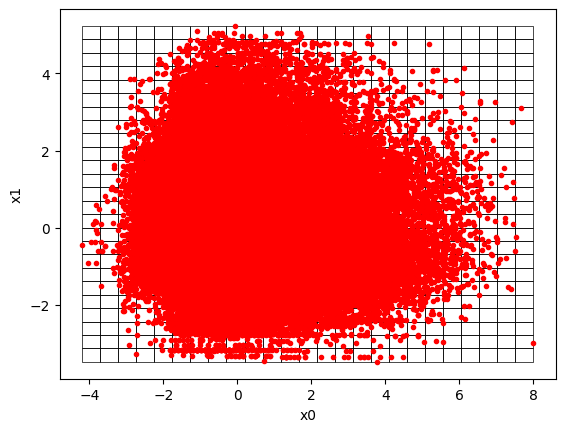

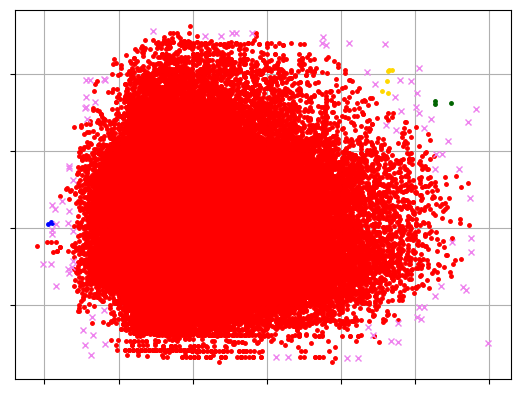

In [13]:
from pyclustering.cluster.clique import clique, clique_visualizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


col_clustering_clique = ['avg_age_participants', 'congressional_district', 'death_level', 'percentage_injured',
                          'unharmed_ratio', 'males_to_females_ratio', 'totalvotes',
                          'density_incident_state', 'avg_age_participants']
#numkilled e poverty percentage

df_for_clique = df_merged_clusterB[col_clustering_clique]

# std scaler
scaler = StandardScaler()
df_for_clique_scaled = scaler.fit_transform(df_for_clique)

# UPCA
pca = PCA(n_components=2)
df_for_clique_pca = pca.fit_transform(df_for_clique_scaled)

# Convert df in numpy array
data_array = np.array(df_for_clique_pca)

# Parameters
intervals = 25  
threshold = 2  

# Clique instance
clique_instance = clique(data_array, intervals, threshold)
clique_instance.process()

# resulta
clusters = clique_instance.get_clusters()
noise = clique_instance.get_noise()
cells = clique_instance.get_cells()

# Visualize clusters
print("Amount of clusters:", len(clusters))
clique_visualizer.show_grid(cells, data_array)
clique_visualizer.show_clusters(data_array, clusters, noise)


COMPARISON WITH DB SCAN

Amount of clusters: 10


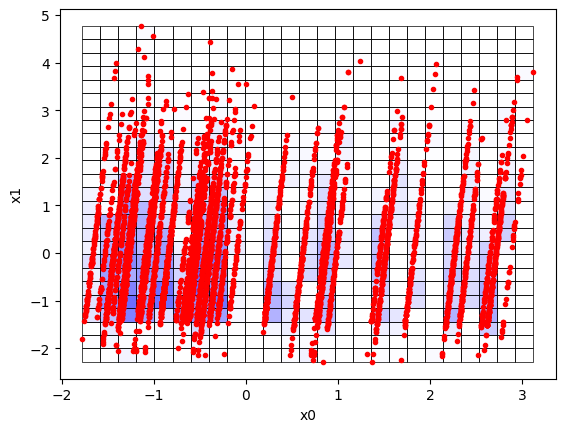

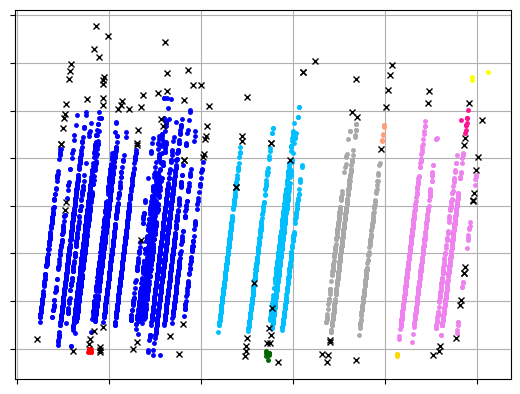

In [16]:
from pyclustering.cluster.clique import clique, clique_visualizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Seleziona colonne per clique
col_clustering_clique = ['avg_age_participants', 'avg_incident_density_per_district', 'congressional_district', 'death_level']

# Prendi solo le colonne per clique
df_for_clique_all = df_merged_clusterB[col_clustering_clique]
#dataframe with onlyt Texas
df_texas_only =  df_merged_clusterB[df_merged_clusterB['state'] == 'Texas']

#dataframe about Texas with only the columns for dbscan
df_for_clique = df_texas_only[col_clustering_dbscan]


# standardize data
scaler = StandardScaler()
df_for_clique_scaled = scaler.fit_transform(df_for_clique)

# pca
pca = PCA(n_components=2)
df_for_clique_pca = pca.fit_transform(df_for_clique_scaled)

# Converti il DataFrame in un array numpy
data_array = np.array(df_for_clique_pca)

# params
intervals = 25  # definisce la quantità di celle nella griglia in ogni dimensione
threshold = 2   # considera ogni punto come non-outlier
#do clique
clique_instance = clique(data_array, intervals, threshold)
clique_instance.process()
clusters = clique_instance.get_clusters()
noise = clique_instance.get_noise()
cells = clique_instance.get_cells()

print("Amount of clusters:", len(clusters))
clique_visualizer.show_grid(cells, data_array)
clique_visualizer.show_clusters(data_array, clusters, noise)



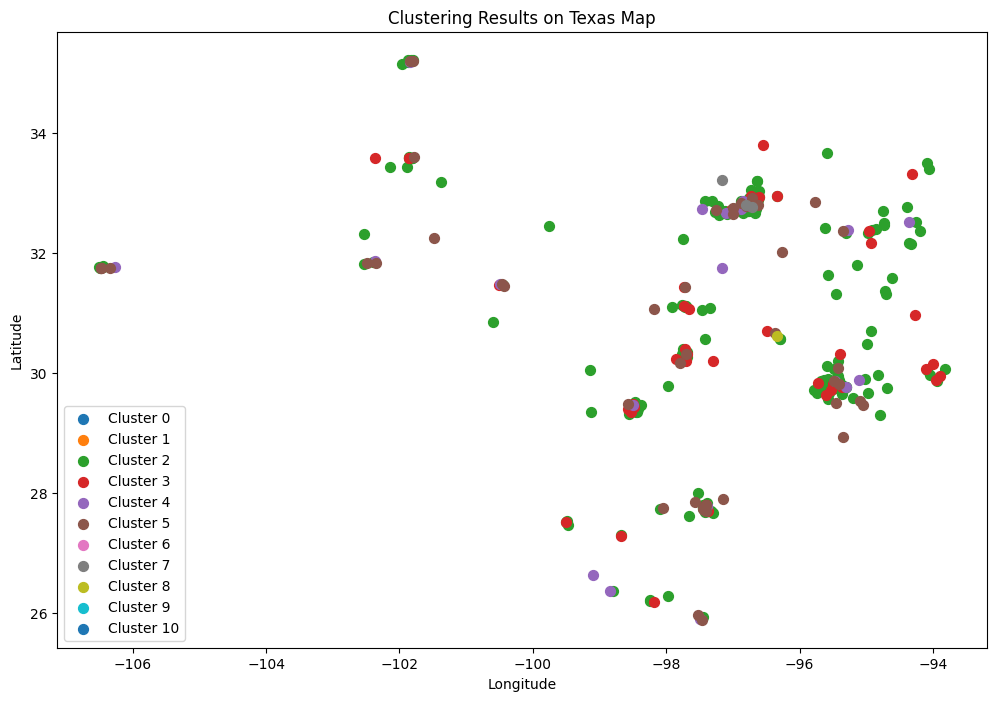

In [19]:

# Converti l'array NumPy in un DataFrame
df_for_clique_pca = pd.DataFrame(data_array, columns=['PC1', 'PC2'])

# Aggiungi la colonna dei cluster
df_for_clique_pca['cluster'] = -1  # Imposta un valore predefinito per i punti di rumore
for i, cluster in enumerate(clusters):
    df_for_clique_pca.loc[cluster, 'cluster'] = i

# Seleziona solo le righe relative allo stato del Texas
df_texas_geo = df_merged_clusterB[df_merged_clusterB['state'] == 'Texas']

# Aggiungi le colonne di latitudine e longitudine al DataFrame df_for_clique_pca
df_for_clique_pca['latitude'] = df_texas_geo['latitude']
df_for_clique_pca['longitude'] = df_texas_geo['longitude']

# Plotta i risultati dei cluster sulla mappa del Texas
plt.figure(figsize=(12, 8))
for cluster in range(len(clusters)):
    cluster_points = df_for_clique_pca[df_for_clique_pca['cluster'] == cluster]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}', s=50)

plt.title('Clustering Results on Texas Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [20]:
from pyclustering.cluster.clique import clique
import numpy as np
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from prettytable import PrettyTable

# Parametri per la grid search
intervals_values = [10, 15, 20, 25]
threshold_values = [1, 2, 3, 4, 5]

def run_clique(data, intervals, threshold):
    clique_instance = clique(data, intervals, threshold)
    clique_instance.process()
    clusters = clique_instance.get_clusters()
    noise = clique_instance.get_noise()
    return clusters, noise

# Inizializza una lista per memorizzare i risultati
results = []

# Esegui la grid search
for intervals_val in tqdm(intervals_values, desc="Intervals"):
    for threshold_val in tqdm(threshold_values, desc="Threshold", leave=False):
        # Applica l'algoritmo di clustering di clique
        clusters, noise = run_clique(data_array, intervals_val, threshold_val)

        # Appiattisci la lista di cluster
        flat_clusters = [-1 if i in noise else j for i, cluster in enumerate(clusters) for j in cluster]

        
        # Memorizza i risultati
        results.append({
            'intervals': intervals_val,
            'threshold': threshold_val,
            'num_clusters': len(clusters),
        })

# Visualizza i risultati della grid search
result_df = PrettyTable()
result_df.field_names = ['intervals', 'threshold', 'num_clusters']
for result in results:
    result_df.add_row([result['intervals'], result['threshold'], result['num_clusters']])

print('Results \n')
print(result_df)

Intervals: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

Results 

+-----------+-----------+--------------+
| intervals | threshold | num_clusters |
+-----------+-----------+--------------+
|     10    |     1     |      1       |
|     10    |     2     |      1       |
|     10    |     3     |      2       |
|     10    |     4     |      1       |
|     10    |     5     |      1       |
|     15    |     1     |      3       |
|     15    |     2     |      3       |
|     15    |     3     |      1       |
|     15    |     4     |      1       |
|     15    |     5     |      2       |
|     20    |     1     |      8       |
|     20    |     2     |      5       |
|     20    |     3     |      4       |
|     20    |     4     |      5       |
|     20    |     5     |      7       |
|     25    |     1     |      11      |
|     25    |     2     |      10      |
|     25    |     3     |      11      |
|     25    |     4     |      10      |
|     25    |     5     |      11      |
+-----------+-----------+--------------+
